In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import res.process_data.dire_and_coor as dc
from res.wgan.genetator import Generator
from res.wgan.critic import Critic
import res.process_data.process_raw_data as prd
from res.process_data.dataset import tensor_dataset
from res.wgan.functions import get_gen_loss, get_crit_loss, get_gradient, gradient_penalty, get_noise
import res.process_data.process_output as out

In [2]:
# prepare the raw data
coordinates_input = prd.read_coordinate(16, "Coordinates.dat")
directions_input = dc.coor_direction_four(coordinates_input)
one_hot_vector = dc.one_hot_four(directions_input)

In [3]:
direction_three_input = dc.coordinate_direction_three(coordinates_input)

In [4]:
n_epochs = 20
z_dim = 8
display_step = 50
batch_size = 128
lr = 0.0003
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cpu'
shuffle = True
num_worker = 4
pin_memory = True

In [ ]:
input_tensor = torch.Tensor(one_hot_vector)
my_dataset = tensor_dataset(input_tensor, 15, 4)
my_dataloader = DataLoader(dataset= my_dataset,
                            shuffle=shuffle,
                            batch_size=batch_size,
                            num_workers=num_worker,
                            pin_memory=pin_memory)

In [7]:
gen = Generator(z_dim, im_dim=60, hidden_dim=16).to(device)
crit = Critic(im_dim=60, hidden_dim=16).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

In [15]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(my_dataloader):
        cur_batch_size = len(real)
        # real_image = real_image.to(device)
        real = real.view(cur_batch_size, -1).to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]
        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins

        cur_step += 1

  0%|          | 0/782 [00:00<?, ?it/s]

Step 50: Generator loss: -1.7135986411571502, critic loss: -0.6391650295257567
Step 100: Generator loss: -2.268216211795807, critic loss: -0.42880485630035403
Step 150: Generator loss: -2.8204606914520265, critic loss: -0.6754165630340576
Step 200: Generator loss: -2.953646388053894, critic loss: -0.3967390127182007
Step 250: Generator loss: -3.045243082046509, critic loss: -0.47101058006286606
Step 300: Generator loss: -3.0418072032928465, critic loss: -0.4430287942886353
Step 350: Generator loss: -2.7984656381607054, critic loss: -0.4929550275802614
Step 400: Generator loss: -3.0947093868255617, critic loss: -0.6182500791549683
Step 450: Generator loss: -2.7551390624046324, critic loss: -0.9638437786102291
Step 500: Generator loss: -2.3970850133895873, critic loss: -0.7013299493789671
Step 550: Generator loss: -2.7559445524215698, critic loss: -0.9484985914230346
Step 600: Generator loss: -3.2986171007156373, critic loss: -0.5120085258483887
Step 650: Generator loss: -2.8142172574996

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

1. sava the parameters and load them into new one.
2. get some output data.
3. get the number of back folding, crossing, and self-avoiding.
4. get the sub-array contains self-avoiding.
5. get the string representing self-avoiding polymer.
6. remove the duplicate from itself and check the different number.
7. check the overlap with raw data.
8. check some statistic value

In [5]:
# save the model
# torch.save({'gen_state_dict': gen.state_dict()}, 'wgan_gen_one_hot.pth.tar')
# torch.save({'crit_state_dict': crit.state_dict()}, 'wgan_crit_one_hot.pth.tar')

In [6]:
# # load the model
# # create a new model, same stracture as the previous one
gen_model = Generator(z_dim, im_dim=60, hidden_dim=16).to(device)
crit_model = Critic(im_dim=60, hidden_dim=16).to(device)
# get the state from stored file
gen_checkpoint = torch.load('wgan_gen_one_hot.pth.tar')
crit_chechpoint = torch.load('wgan_crit_one_hot.pth.tar')
# load the state to the new model
gen_model.load_state_dict(gen_checkpoint['gen_state_dict'])
crit_model.load_state_dict(crit_chechpoint['crit_state_dict'])

<All keys matched successfully>

get output data

In [8]:
coordinate_output = np.zeros([16000, 16 ,2])
for i in range(1000):
    noise = get_noise(16, 8)
    output = gen_model(noise).data.numpy()
    for j in range(16):
        one_hot_matrix = out.slicing_output(output[j], "onehot")
        direction = out.one_hot_to_direction_four(one_hot_matrix)
        coordinate = out.four_direction_to_coordinates(direction)
        coordinate_output[(i * 16) + j] = coordinate

count the back folding and corss

In [9]:
folding_count, crossing_count, self_avoid = out.count_fold_cross(coordinate_output)
print (folding_count, crossing_count, self_avoid)
print (folding_count/16000, crossing_count/16000, self_avoid/16000)

5038 5823 7869
0.314875 0.3639375 0.4918125


get the sub-array contains self-avoiding.

In [10]:
self_avoid_output = out.arrange_self_avoid_polymer(coordinate_output, self_avoid)

convert coordinates to three direction, and remove duplicate

In [11]:
direction_three = dc.coordinate_direction_three(self_avoid_output)
removed_duplicated, directions_str = out.remove_duplicated(direction_three)

In [12]:
len(removed_duplicated)

6292

check overlap with raw data

In [13]:
direction_three_input = dc.coordinate_direction_three(coordinates_input)
input_removed_dupicated_str, input_direction_str = out.remove_duplicated(direction_three_input)
from tqdm.auto import tqdm
repeat = 0
for output in tqdm(removed_duplicated):
    if output in input_removed_dupicated_str:
        repeat += 1
repeat

  0%|          | 0/6292 [00:00<?, ?it/s]

407

get the statistic values

In [14]:
distance_array = np.zeros(16000)
for i in range(16000):
    distance_array[i]= out.n_n_distance(coordinate_output[i])
out.statistics(distance_array)

(6.34672323210437, 2.6295159659273137, 6.914354215066655)

In [15]:
input_distance = np.zeros(100000)
for i in range(100000):
    input_distance[i]= out.n_n_distance(coordinates_input[i])
out.statistics(input_distance)

(6.499296237636025, 2.262412079054168, 5.118508415450203)

<AxesSubplot:ylabel='Count'>

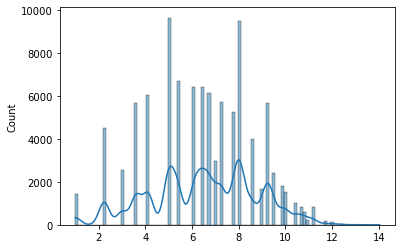

In [17]:
sns.histplot(data=input_distance, kde=True)

<AxesSubplot:ylabel='Count'>

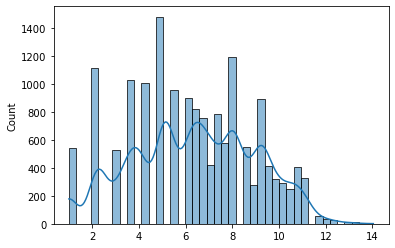

In [18]:
sns.histplot(data=distance_array, kde=True)

In [25]:
output_list = []
for k in range(100):
    noise = get_noise(16, 8)
    output = gen_model(noise).data.numpy()
    for i in range(16):
        for j in range(60):
            output_list.append(output[i][j])

<AxesSubplot:ylabel='Count'>

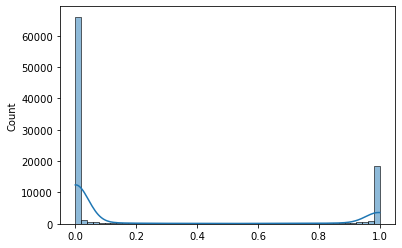

In [26]:
sns.histplot(data=output_list, kde=True)

In [21]:
noise = get_noise(16, 8)
output = gen_model(noise).data.numpy()


In [24]:
len(output[0])

60